# Multilayer Perceptron Neural Network with backpropagation

## Algorithme détaillé sous forme matricielle (Pseudo-code)

#### **1. Propagation**

##### **1.1 Couche d'entrée :**

Propager les données en entrées avec  $ A^{(1)} = XW^{(in → 1)}$.

où :


- $ A^{(i)} $ : est la matrice qui contient les _inputs_ de la couche $i$.
- $ X $ : est une matrice n x m avec n exemple qui ont m features.
- $ W^{(i→j)} $ : est la matrice de poids entre la couche $i$ et la couche $j$. Note importante: $ W $ est considéré ici comme étant l'équivalent de $\Theta$ nous avons donc :  $ W = \Theta = [W \; b] $ où $b$ est le biais. Les matrices d'entrées sont ajustées en conséquence avec l'ajout d'une colonne de $1$ à la fin de celles-ci.

##### **1.2 Couches cachées :**

Pour chaque couche cachée :

Évaluer $ H^{(i)} = f_{ReLU}({A^{(i)}})$  et l'enregistrer pour la présente couche. 

Propager les données reçues en entrée avec $ A^{(j)} = H^{(i)}W^{(i → j)}$.

Enregistrer la dérivié de la fonction d'activation appliquée à $A^{(i)}$ pour la rétropropaganation, $ Hp^{(i)} = (f_{ReLU}^{'}({A^{(i)}}))^T$. 


où :


- $ H^{(i)} $ : est la matrice résultante de l'application de la fonction $f_{ReLU}$ à la matrice $ A^{(i)} $
- $ f_{ReLU} $ : est la fonction d'activation. Ici la fonction d'activation utilisée pour les couches cachées est la fonction $ReLU$.
- $ f_{ReLU}^{'} $ : est la dérivée de la fonction d'activation $ f_{ReLU} $.
- $ Hp^{(i)} $ : est la matrice qui contient les dérivées de la fonction d'activation.


##### **1.3 Couche de sortie :**

Propager la prédiction pour $ H_{iy}^{(out)} = f_{Softmax}({A^{(L+1)}})$.

où :

- $ f_{Softmax} $ : est la fonction d'activation. Ici la fonction d'activation utilisée pour la couche de sortie est la fonction $Softmax$.

#### **2. Rétropropagation**

Initialiser la matrice des deltas $D$ de la couche de sortie avec $ D^{(out)} = (H^{out} - Y)^T $. 



Pour chaque couche cachée (de la dernière à la première) : Mettre à jour la matrice $D$ avec $ D^{(i)} = Fp^{(i)} ⊙ W^{(i→j)} D^{(j)}$.

où :

- $D^{(i)}$ est la matrice des deltas associée à la couche $i$. 
- ⊙ est la multiplication par élément.


#### **3. Mise à jour des poids**

Mettre à jour les poids de la couche d'entrée avec $W^{(in→1)} = W^{(in→1)} −η(D^{(1)}X)^T$.

Mettre à jour les poids des couches cachées avec $W^{(i→j)} = W^{(i→j)} −η(D^{(j)}H^{(i)})^T$

où :

- η : est le taux d'apprentissage.


## Implémentation

Caractéristiques du réseau: 
- Une couche d'entrée de 784 unités.
- Deux couches cachées de 300 unités.
- Une couche de sortie de 10 unités.
- Une taille de minibatch de 256.
- Un nombre d’epoch de 100.
- Une fonction d’activation ReLU pour les couches cachées.
- Une fonction d’activation Softmax pour la couche de sortie.
- La fonction de coût (loss function) est la cross-entropy.
- Un taux d’apprentissage de 0.001.


### Implémentation du réseau sans librairie

In [0]:
import matplotlib.pyplot as plt

def plot_accuracies(train_accuracies, validation_accuracies):   
    plt.figure(figsize=(12,12))
    plt.rcParams.update({'font.size': 15})
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch") 
    plt.plot(train_accuracies, label="train")
    plt.plot(validation_accuracies, label="validation")
    plt.legend(loc="upper right")
        
    plt.show()

In [0]:
def plot_losses(train_losses, validation_losses):   
    plt.figure(figsize=(12,12))
    plt.rcParams.update({'font.size': 15})
    plt.ylabel("Loss")
    plt.xlabel("Epoch") 
    plt.plot(train_losses, label="train")
    plt.plot(validation_losses, label="validation")
    plt.legend(loc="upper right")
        
    plt.show()

In [0]:
import numpy as np
import time

class Layer:
    # Activation function
    def h_relu(self, X):
        return np.maximum(0, X)
    
    # Derivative of activation function
    def hp_relu(self, X):
        X[X <= 0] = 0
        X[X > 0] = 1
        return X
    
    # Activation function of output layer
    def f_softmax(self, x):
        e_x = np.exp(x - np.max(x, axis = 1, keepdims = True))
        return e_x / e_x.sum(axis=1, keepdims = True)

    def __init__(self, layer_id, size, minibatch_size, is_input=False, is_output=False):
        self.is_input = is_input
        self.is_output = is_output
        self.layer_id = layer_id

        # H contient les données de sorties de la présente couche
        self.H = np.zeros((minibatch_size, size[0]))
        # W contient les poids
        self.W = None
        # A contient les données en entrée de la présente couche
        self.A = None
        # D contient les deltas de la présente couche
        self.D = None
        # Hp contient les dérivés de la fonction d'activation
        self.Hp = None

        if is_output:
            self.activation = self.f_softmax
        else:
            self.activation = self.h_relu

        if not is_input:
            self.A = np.zeros((minibatch_size, size[0]))
            self.D = np.zeros((minibatch_size, size[0]))

        if not is_output:
            np.random.seed(42)
            self.W = np.random.normal(0, 0.01, size)

        if not is_input and not is_output:
            self.Hp = np.zeros((size[0], minibatch_size))

        
    def forward_propagate(self):
        # For input Layer
        if self.is_input:
            return np.matmul(self.H, self.W)

        # For output Layer, (no bias added)
        if self.is_output:
            return self.activation(self.A)

        # For hidden layers, we add the bias values here
        self.H = self.activation(self.A)
        self.H = np.append(self.H, np.ones((self.H.shape[0], 1)), axis=1)
        self.Hp = self.hp_relu(self.A).T

        return np.matmul(self.H, self.W)


class NN:
    def __init__(self, layer_config, minibatch_size):
        self.layers = []
        self.num_layers = len(layer_config)
        self.minibatch_size = minibatch_size

        for i in range(self.num_layers-1):
            if i == 0:
                # Here, we add an additional unit at the input for the bias weight.
                size = (layer_config[i]+1, layer_config[i+1])
                self.layers.append(Layer("Input layer ", size, minibatch_size, is_input=True))
            else:
                # Here we add an additional unit in the hidden layers for the bias weight.
                size = (layer_config[i]+1, layer_config[i+1])
                self.layers.append(Layer("Hidden layer " + str(i), size, minibatch_size))


        size = (layer_config[-1], None)
        self.layers.append(Layer("Output layer ", size, minibatch_size, is_output=True))

    def forward_propagate(self, data):
        # We need to be sure to add bias values to the input
        self.layers[0].H = np.append(data, np.ones((data.shape[0], 1)), axis=1)

        for i in range(self.num_layers - 1):
            self.layers[i+1].A = self.layers[i].forward_propagate()
        return self.layers[-1].forward_propagate()

    def backpropagate(self, yhat, labels):     
        self.layers[-1].D = (yhat - labels).T

        for i in range(self.num_layers - 2, 0, -1):
            W_nobias = self.layers[i].W[0:-1, :]
            self.layers[i].D = np.matmul(W_nobias, self.layers[i+1].D) * self.layers[i].Hp 

    def update_weights(self, eta):
        for i in range(0, self.num_layers-1):
            W_grad = -eta*(np.matmul(self.layers[i+1].D, self.layers[i].H)).T
            self.layers[i].W += W_grad

    def get_loss(self, y, y_pred):        
        y_pred[y_pred == 0.0] = 1.0e-10
        y_pred[y_pred == 1.0] = 1 - 1.0e-10
        
        m = len(y)
        log_proba = np.log(y_pred)
        cost = y*log_proba
        
        return -np.sum(cost) / m

    def get_accuracy(self, y_pred, y):       
        y_pred_class = np.argmax(y_pred, axis=1) 
        y_class = np.argmax(y, axis=1)
        n = len(y)

        return np.sum(y_class == y_pred_class) / n

    # Propagate forward through the network, record the training error, train the
    # weights with backpropagation
    def train(self, X, Y, eta):
        output = self.forward_propagate(X)
        self.backpropagate(output, Y)
        self.update_weights(eta=eta)

    # Just pass the data forward through the network and return the predictions
    def test(self, X):
        return self.forward_propagate(X)

    def evaluate(self, X_train, y_train, X_validation, y_validation, num_epochs=500, eta=0.001):
        startTime = time.time()

        train_losses = []
        validation_losses = []

        train_accuracies = []
        validation_accuracies = []

        for t in range(num_epochs):
            for i in range(0, X_train.shape[0], self.minibatch_size):  
                X_train_minibatch = X_train[i:i + self.minibatch_size]
                y_train_minibatch = y_train[i:i + self.minibatch_size]

                output = self.forward_propagate(X_train_minibatch)
                self.backpropagate(output, y_train_minibatch)
                self.update_weights(eta)

            
            # compute the loss on the train set
            train_loss = self.get_loss(y_train, self.test(X_train))
            train_losses.append(train_loss)
            # compute the loss on the validation set
            val_loss = self.get_loss(y_validation, self.test(X_validation))
            validation_losses.append(val_loss)

            # compute the loss on the train set
            train_acc = self.get_accuracy(self.test(X_train), y_train)
            train_accuracies.append(train_acc)
            # compute the loss on the validation set
            val_acc = self.get_accuracy(self.test(X_validation), y_validation)
            validation_accuracies.append(val_acc)

            elapsedTime = (time.time()-startTime)
            output_str = "Epoch nb.: " + str(t+1)
            output_str += " - Elapsed time : " + str(round(elapsedTime, 4))
            output_str += " - train_loss : " + str(round(train_loss, 4))
            output_str += " - train_acc : " + str(round(train_acc, 4))
            output_str += " - validation_loss : " + str(round(val_loss, 4))
            output_str += " - validation_acc : " + str(round(val_acc, 4))
            print(output_str)

        plot_accuracies(train_accuracies, validation_accuracies)
        plot_losses(train_losses, validation_losses)



Epoch nb.: 1 - Elapsed time : 11.4133 - train_loss : 0.6188 - train_acc : 0.7758 - validation_loss : 0.6411 - validation_acc : 0.7663
Epoch nb.: 2 - Elapsed time : 22.7756 - train_loss : 0.466 - train_acc : 0.8339 - validation_loss : 0.494 - validation_acc : 0.8236
Epoch nb.: 3 - Elapsed time : 34.0824 - train_loss : 0.411 - train_acc : 0.8513 - validation_loss : 0.4458 - validation_acc : 0.8401
Epoch nb.: 4 - Elapsed time : 45.4225 - train_loss : 0.3822 - train_acc : 0.861 - validation_loss : 0.4221 - validation_acc : 0.8487
Epoch nb.: 5 - Elapsed time : 57.0547 - train_loss : 0.3572 - train_acc : 0.8709 - validation_loss : 0.4014 - validation_acc : 0.8543
Epoch nb.: 6 - Elapsed time : 68.4964 - train_loss : 0.3399 - train_acc : 0.8764 - validation_loss : 0.3877 - validation_acc : 0.8583
Epoch nb.: 7 - Elapsed time : 79.856 - train_loss : 0.328 - train_acc : 0.88 - validation_loss : 0.3797 - validation_acc : 0.8618
Epoch nb.: 8 - Elapsed time : 91.2716 - train_loss : 0.3162 - train_ac

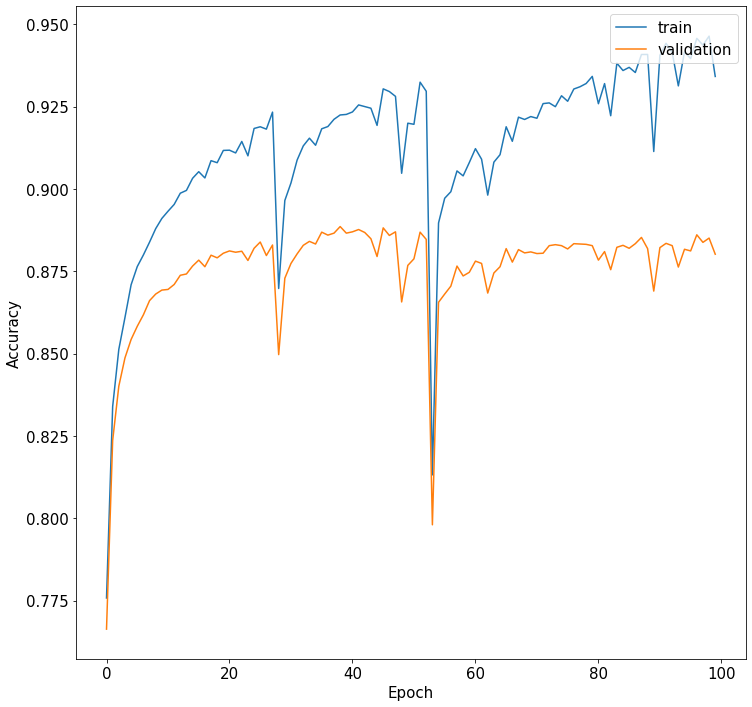

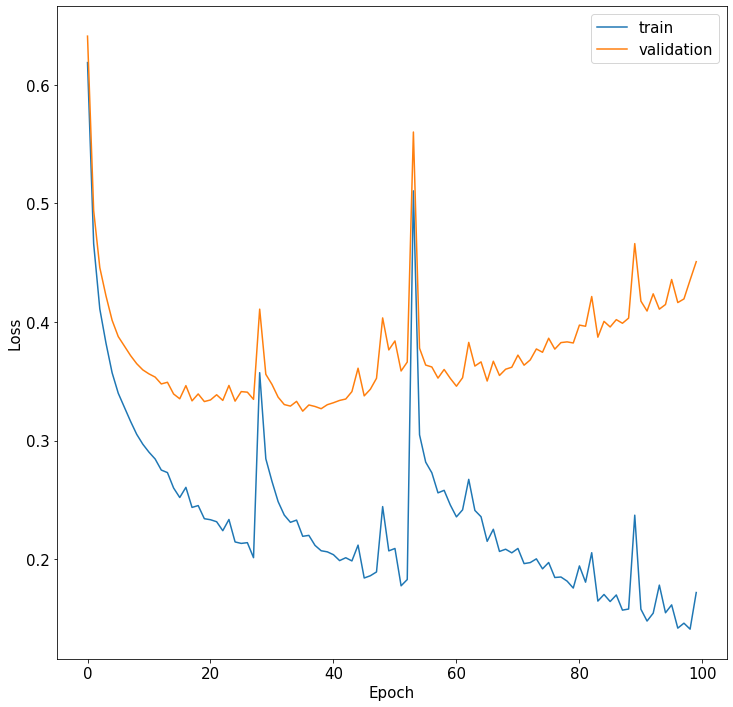

Finished


In [0]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from tensorflow import keras

data = keras.datasets.fashion_mnist

(train_images, train_labels), (validation_images, validation_labels) = data.load_data()


train_images = train_images / 255.0
validation_images = validation_images / 255.0


X_train = train_images
X_train = X_train.flatten().reshape(60000, 784)

y_train = np.zeros((train_labels.shape[0], len(np.unique(train_labels))))
y_train[np.arange(train_labels.shape[0]), train_labels] = 1  # one hot target or shape NxK


X_validation = validation_images
X_validation = X_validation.flatten().reshape(10000, 784)

y_validation = np.zeros((validation_labels.shape[0], len(np.unique(validation_labels))))
y_validation[np.arange(validation_labels.shape[0]), validation_labels] = 1  # one hot target or shape NxK


nn = NN(layer_config=[784, 300, 300, 10], minibatch_size=256)
nn.evaluate(X_train, y_train, X_validation, y_validation, num_epochs=100, eta=0.001)

print("Finished")

### Implémentation du réseau avec Keras

In [1]:
import keras
from keras import optimizers
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.utils import plot_model
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Plot training & validation accuracy/loss values
def plot(acc_loss, history, batch_size, nb_epochs):
    plt.plot(history.history[acc_loss])
    plt.plot(history.history['val_' + acc_loss])
    plt.title('Model ' + acc_loss + ' avec batch_size de ' + str(batch_size) + " sur " + str(nb_epochs) + " epochs")
    plt.ylabel(acc_loss.capitalize())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [3]:
((x_train, y_train), (x_test, y_test)) = fashion_mnist.load_data()

x_train = x_train.reshape(60000,28,28)
# L'ensemble de test fourni par Keras est utilisé comme ensemble de validation
x_test = x_test.reshape(10000,28,28)

x_train = x_train / 255.0
x_test = x_test / 255.0

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 3s 46us/step - loss: 2.1260 - accuracy: 0.3072 - val_loss: 1.9347 - val_accuracy: 0.5248
Epoch 2/100
60000/60000 [==============================] - 3s 49us/step - loss: 1.7851 - accuracy: 0.5987 - val_loss: 1.6544 - val_accuracy: 0.6219
Epoch 3/100
60000/60000 [==============================] - 3s 48us/step - loss: 1.5379 - accuracy: 0.6421 - val_loss: 1.4421 - val_accuracy: 0.6425
Epoch 4/100
60000/60000 [==============================] - 2s 38us/step - loss: 1.3526 - accuracy: 0.6554 - val_loss: 1.2856 - val_accuracy: 0.6517
Epoch 5/100
60000/60000 [==============================] - 2s 38us/step - loss: 1.2167 - accuracy: 0.6649 - val_loss: 1.1709 - val_accuracy: 0.6616
Epoch 6/100
60000/60000 [==============================] - 2s 38us/step - loss: 1.1165 - accuracy: 0.6729 - val_loss: 1.0858 - val_accuracy: 0.6689
Epoch 7/100
60000/60000 [==============================] - 2s 

Epoch 56/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.5302 - accuracy: 0.8231 - val_loss: 0.5506 - val_accuracy: 0.8142
Epoch 57/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.5280 - accuracy: 0.8233 - val_loss: 0.5482 - val_accuracy: 0.8150
Epoch 58/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.5256 - accuracy: 0.8241 - val_loss: 0.5464 - val_accuracy: 0.8147
Epoch 59/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.5234 - accuracy: 0.8246 - val_loss: 0.5442 - val_accuracy: 0.8154
Epoch 60/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.5213 - accuracy: 0.8251 - val_loss: 0.5423 - val_accuracy: 0.8155
Epoch 61/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.5191 - accuracy: 0.8256 - val_loss: 0.5403 - val_accuracy: 0.8160
Epoch 62/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.5171 - accuracy: 0.8260

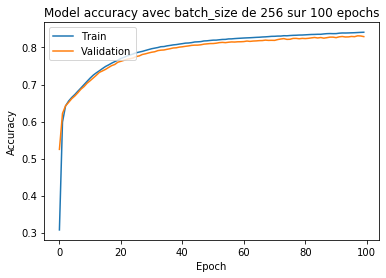

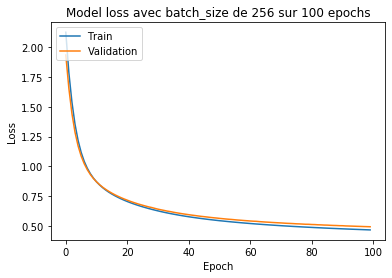

In [4]:
model = Sequential()

model.add(Flatten())

model.add(Dense(units=300, activation='relu'))
model.add(Dense(units=300, activation='relu'))

model.add(Dense(units=10, activation='softmax'))

sgd = optimizers.SGD(lr=0.001, decay=0, momentum=0.0, nesterov=False)
model.compile(sgd, loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 256
nb_epochs = 100
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=nb_epochs, batch_size=batch_size)

plot("accuracy", history, batch_size, nb_epochs)
plot("loss", history, batch_size, nb_epochs)

### Références 

Ces ressources ont été utilisées comme inspiration pour la structure du code et validation des dérivations obtenues. 

[1] I-Ta Lee's Notes on Backpropagation with Cross Entropy: https://doug919.github.io/notes-on-backpropagation-with-cross-entropy/

[2] BRIAN DOLHANSKY's Artificial Neural Networks blog: http://www.briandolhansky.com/blog?fbclid=IwAR3TvmZS6Ox7rXNJR9izruY5Iwcf_ovEIXiIy0Gr8kYeqgmYxuAA45arpAM

[3] Backpropagation - Wikipedia: https://en.wikipedia.org/wiki/Backpropagation